In [8]:
import torch
import smbus
import time
import struct

In [9]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available — check installation.")

PyTorch version: 1.7.0
CUDA available: True
GPU device: NVIDIA Tegra X1


Test rotation speed

In [21]:
robot.left(0.5)   # ← your desired ROT_SPEED
time.sleep(1.0)   # spin for 1 second
robot.stop()

Test Ultrasonic Sensors

In [10]:
import smbus
import time

bus = smbus.SMBus(1)
address = 8          # I2C address of Feather

def distance_cm1():
    """Read ONLY Sensor 1 (cm1) – 4 bytes little-endian."""
    data = bus.read_i2c_block_data(address, 0, 4)  # <-- 4 bytes
    cm1  = data[0] | (data[1] << 8) | (data[2] << 16) | (data[3] << 24)
    return cm1

while True:
    d = distance_cm1()
    print(f"Sensor 1: {d} cm")
    time.sleep(1.0)


Sensor 1: 38 cm
Sensor 1: 48 cm
Sensor 1: 48 cm
Sensor 1: 48 cm
Sensor 1: 48 cm
Sensor 1: 49 cm
Sensor 1: 49 cm
Sensor 1: 8 cm
Sensor 1: 6 cm
Sensor 1: 8 cm
Sensor 1: 9 cm


KeyboardInterrupt: 

In [19]:
"""
Square-arena navigation with 1 front-mounted ultrasonic sensor
──────────────────────────────────────────────────────────────
* Board size            : 240 cm × 240 cm
* Sensor I²C            : Feather M0 @ address 0x08
* Sensor orientation    : 0°  (facing forward)
* Robot platform        : NVIDIA JetBot (differential drive)
* Pipeline              : 1) 360° scan  → pose
                          2) Pure Pursuit → centre
                          3) Optional re-localisation on the way
                          4) Save wall hits + trajectory for plotting
"""

import numpy as np, time, smbus, matplotlib.pyplot as plt
from jetbot import Robot

# ───── CONSTANTS ────────────────────────────────────────────
I2C_BUS, I2C_ADDRESS = 1, 0x08
ARENA_W, ARENA_H     = 240.0, 240.0          # cm
SENSOR_RANGE         = (2.0, 400.0)          # cm
SENSOR_OFF           = 0.0                   # forward-facing
STEP_DEG             = 3
ROT_DEG_PER_SEC      = 20.0
ROT_SPEED            = 0.5
BASE_SPEED           = 0.35
LOOKAHEAD_DIST       = 12.0                  # cm
LOOP_DT              = 0.10                  # s
RELLOC_PERIOD        = 6.0                   # s (0 = off)

# ───── INITIALISE HARDWARE ─────────────────────────────────
bus   = smbus.SMBus(I2C_BUS)
robot = Robot()

# ───── UTILITY FUNCTIONS ───────────────────────────────────
def read_cm1():
    d = bus.read_i2c_block_data(I2C_ADDRESS, 0, 4)
    return d[0] | (d[1]<<8) | (d[2]<<16) | (d[3]<<24)

wrap_pi = lambda a: (a+np.pi)%(2*np.pi)-np.pi

def rotate_pts(pts, theta):
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return pts @ R.T

# ───── 1) FULL 360° SCAN ───────────────────────────────────
def full_scan(step_deg=STEP_DEG):
    hits, steps = [], int(360/step_deg)
    for k in range(steps):
        d = read_cm1()
        if SENSOR_RANGE[0] <= d <= SENSOR_RANGE[1]:
            ang = np.deg2rad(k*step_deg) + SENSOR_OFF
            hits.append((d*np.cos(ang), d*np.sin(ang)))
        robot.left(ROT_SPEED)
        time.sleep(step_deg/ROT_DEG_PER_SEC)
        robot.stop(); time.sleep(0.03)
    return hits

# ───── 2) POSE ESTIMATION ──────────────────────────────────
def estimate_pose_from_hits(hits_robot, arena_w=ARENA_W, arena_h=ARENA_H):
    pts = np.asarray(hits_robot)
    if pts.shape[0] < 20: return None
    best_err, best_theta, best_min = 1e9, None, None
    for deg in range(-90, 90):                          # 180° range is enough
        th = np.deg2rad(deg)
        rot = rotate_pts(pts, th)
        minx,maxx, miny,maxy = rot[:,0].min(),rot[:,0].max(), rot[:,1].min(),rot[:,1].max()
        err = abs((maxx-minx)-arena_w) + abs((maxy-miny)-arena_h)
        if err<best_err: best_err,best_theta,best_min = err,th,(minx,miny)
    if best_theta is None: return None
    x_world,y_world = -best_min[0], -best_min[1]
    return x_world, y_world, wrap_pi(best_theta)

# ───── 3) PURE-PURSUIT CONTROLLER ──────────────────────────
find_lookahead = lambda pos, path, L=LOOKAHEAD_DIST: \
    next((np.array(p) for p in path[1:] if np.hypot(p[0]-pos[0], p[1]-pos[1])>=L), np.array(path[-1]))

def pure_pursuit_step(position, heading, lookahead):
    x,y = position; dx,dy = lookahead[0]-x, lookahead[1]-y
    lx  =  np.cos(-heading)*dx - np.sin(-heading)*dy
    ly  =  np.sin(-heading)*dx + np.cos(-heading)*dy
    if lx<=0.01: return -BASE_SPEED, BASE_SPEED
    curv = 2*ly/(lx**2+ly**2);  ω = BASE_SPEED*curv
    l,r  = BASE_SPEED-ω, BASE_SPEED+ω
    m = max(abs(l),abs(r),1.0)
    return l/m, r/m

# ───── 4) MAIN NAV LOOP  (+ SAVE DATA) ─────────────────────
def drive_to_center(initial_pose, wall_hits_world, relocalise_period=RELLOC_PERIOD):
    x,y,θ   = initial_pose
    goal    = np.array([ARENA_W/2, ARENA_H/2])
    path    = [initial_pose[:2], goal]
    t_last  = time.time()
    trajectory = [(x,y)]                      # ⇦ record path
    print(f"Start pose ≈ ({x:.1f},{y:.1f},{np.rad2deg(θ):.1f}°)")

    while True:
        # Pure Pursuit
        lookahead   = find_lookahead((x,y), path)
        ls,rs       = pure_pursuit_step((x,y), θ, lookahead)
        robot.set_motors(ls, rs);  time.sleep(LOOP_DT)

        # Dead-reckoning
        dist = BASE_SPEED*LOOP_DT*100
        x += dist*np.cos(θ);  y += dist*np.sin(θ)
        θ  = wrap_pi(np.arctan2(goal[1]-y, goal[0]-x))
        trajectory.append((x,y))

        # Goal check
        if np.hypot(goal[0]-x, goal[1]-y) < 4: break

        # Periodic re-localisation
        if relocalise_period>0 and time.time()-t_last>=relocalise_period:
            robot.stop(); time.sleep(0.2)
            new_hits = full_scan()
            pose = estimate_pose_from_hits(new_hits)
            if pose:
                x,y,θ = pose
                wh = rotate_pts(np.asarray(new_hits), θ) + np.array([[x,y]])
                wall_hits_world.extend(wh.tolist())          # ⇦ log extra hits
                print(f"↺ Relocalised → ({x:.1f},{y:.1f})")
            t_last = time.time()

        print(f"• Est ({x:.1f},{y:.1f})  dist→goal {np.hypot(goal[0]-x, goal[1]-y):.1f} cm", end='\r')

    robot.stop(); print("\n✅ Centre reached.")
    return trajectory, (x,y,θ)

In [20]:
try:
    print("🔄 360° scan …")
    raw_hits = full_scan()
    pose     = estimate_pose_from_hits(raw_hits)
    if pose is None: raise RuntimeError("Initial localisation failed.")

    # Convert first scan to world frame & store
    wall_hits_world = (rotate_pts(np.asarray(raw_hits), pose[2])
                       + np.array([[pose[0], pose[1]]])).tolist()

    traj, final_pose = drive_to_center(pose, wall_hits_world)

    # Save everything
    np.savez("robot_run.npz",
             wall_hits=np.asarray(wall_hits_world),
             trajectory=np.asarray(traj),
             final_pose=np.asarray(final_pose))
    print("📁  Data saved to robot_run.npz")

except KeyboardInterrupt:
    print("\n⛔ Interrupted by user.")
finally:
    robot.stop()


🔄 360° scan …

⛔ Interrupted by user.


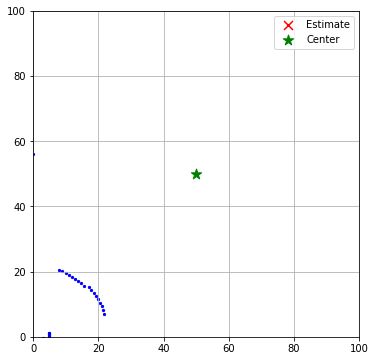

In [12]:
import numpy as np, matplotlib.pyplot as plt
ARENA_W, ARENA_H = 240, 240          # ← keep in sync

d = np.load("robot_run.npz", allow_pickle=True)
hits = d["wall_hits"];  traj = d["trajectory"];  final = d["final_pose"]

plt.figure(figsize=(6,6))
plt.scatter(hits[:,0], hits[:,1], s=4, label="Wall hits", alpha=.6)
plt.plot(traj[:,0], traj[:,1], '-o', ms=3, label="Trajectory")
plt.scatter(final[0], final[1], c='r', marker='x', s=80, label="Final pose")
plt.scatter(ARENA_W/2, ARENA_H/2, c='g', marker='*', s=120, label="Goal centre")
plt.xlim(0,ARENA_W); plt.ylim(0,ARENA_H); plt.gca().set_aspect('equal')
plt.grid(); plt.legend(); plt.title("Robot Navigation Run")
plt.show()
